In [2]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 

In [3]:
## load data set
carmax_df = pd.read_csv('CaseDataRemodeled.csv')
top10_df = pd.read_csv('Top10ByIncome.csv')

## Time to Cluster - Gonna use k-means initially 




In general, we can cluster observations on the basis of the features in order to identify subgroups among the observations, or we can cluster fea- tures on the basis of the observations in order to discover subgroups among the features. In what follows, for simplicity we will discuss clustering obser- vations on the basis of the features, though the converse can be performed by simply transposing the data matrix.

In [4]:
top10_df.columns
top10_df = top10_df.drop('Unnamed: 0', axis=1)

In [5]:
top10_df['purchase_model']

0        CAMRY
1       ALTIMA
2      COROLLA
3       MALIBU
4       ACCORD
        ...   
115     ACCORD
116    COROLLA
117      CIVIC
118       CR-V
119      FOCUS
Name: purchase_model, Length: 120, dtype: object

In [6]:
cluster_df = carmax_df[carmax_df['purchase_model'].isin(list(set(top10_df['purchase_model'])))]
cluster_df = cluster_df.drop('insert_num', axis=1)

In [7]:
cluster_df

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,post_purchase_satisfaction,vehicle_warranty_used,subsequent_purchases,AgeBin
1,FORD,F150,2007,15001.0,20000.0,0,0,51 - 60,0 - 20000,F,1,19.0,?,0,0,Fifties
2,BMW,328,2010,25001.0,30000.0,1,1,41 - 50,60001 - 80000,F,1,21.0,?,0,0,Forties
5,NISSAN,ALTIMA,2009,15001.0,20000.0,1,1,21 - 30,60001 - 80000,U,0,2.0,?,1,1,Twenties
8,FORD,ESCAPE,2010,15001.0,20000.0,1,1,41 - 50,40001 - 60000,U,1,14.0,?,1,0,Forties
10,NISSAN,SENTRA,2009,10001.0,15000.0,0,1,61 - 70,20001 - 40000,U,0,NaN,?,0,1,Sixties
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355854,FORD,FOCUS,2013,20001.0,25000.0,1,1,31 - 40,100001 - 120000,M,1,4.0,?,0,2,Thirties
355860,HYUNDAI,SONATA,2011,20001.0,25000.0,1,0,41 - 50,?,M,0,7.0,?,0,1,Forties
355864,HONDA,ACCORD,2007,15001.0,20000.0,0,1,21 - 30,20001 - 40000,F,0,12.0,?,0,0,Twenties
355866,TOYOTA,RAV4,2011,20001.0,25000.0,1,1,51 - 60,40001 - 60000,F,1,3.0,?,0,0,Fifties


In [8]:
len(list(set(top10_df['purchase_model'])))

30

In [9]:
cluster_df.dtypes

purchase_make                   object
purchase_model                  object
purchase_vehicle_year            int64
purchase_price_LB              float64
purchase_price_UB              float64
trade_in                         int64
vehicle_financing                int64
customer_age                    object
customer_income                 object
customer_gender                 object
customer_previous_purchase       int64
customer_distance_to_dealer    float64
post_purchase_satisfaction      object
vehicle_warranty_used            int64
subsequent_purchases             int64
AgeBin                          object
dtype: object

In [10]:
cluster_df = cluster_df.drop('customer_age', axis=1)
cluster_df = cluster_df.drop('post_purchase_satisfaction', axis=1)

In [11]:
# function to transform into numerical bins by normal/gaussian distribution
def categorical_transform(col):
    classnames, factorval, rank = np.unique(col, return_inverse = True,return_counts = True)
    
    temp = np.array(rank)
    temp.sort()
    temp = np.concatenate((temp[::2], temp[~np.isin(temp,temp[::2])][::-1]))

    category_count = {}
    for i in range(len(classnames)):
        category_count[classnames[i]] = rank[i]
    
    vals = [i * 5 for i in range(len(temp))]
    
    for i in range(len(temp)):
        for key, value in category_count.items():
            if value == temp[i]:
                category_count[key] = vals[i]
            
    check_list = list(col)
    for i in range(len(check_list)):
        for key, value in category_count.items():
            if check_list[i] == key:
                factorval[i] = value 
                break
    
    return category_count, factorval

In [12]:
## references of transformation for later 
references = {}

for i in cluster_df.columns:
    if cluster_df[i].dtype == 'object':
        classes = cluster_df[i]
        references[i], cluster_df[i] = categorical_transform(classes)

In [13]:
cluster_df.dtypes

purchase_make                    int64
purchase_model                   int64
purchase_vehicle_year            int64
purchase_price_LB              float64
purchase_price_UB              float64
trade_in                         int64
vehicle_financing                int64
customer_income                  int64
customer_gender                  int64
customer_previous_purchase       int64
customer_distance_to_dealer    float64
vehicle_warranty_used            int64
subsequent_purchases             int64
AgeBin                           int64
dtype: object

In [14]:
cluster_df

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin
1,20,90,2007,15001.0,20000.0,0,0,40,10,1,19.0,0,0,35
2,50,25,2010,25001.0,30000.0,1,1,20,10,1,21.0,0,0,20
5,30,75,2009,15001.0,20000.0,1,1,20,0,0,2.0,1,1,25
8,20,50,2010,15001.0,20000.0,1,1,25,0,1,14.0,1,0,20
10,30,45,2009,10001.0,15000.0,0,1,30,0,0,NaN,0,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355854,20,100,2013,20001.0,25000.0,1,1,45,5,1,4.0,0,2,30
355860,45,95,2011,20001.0,25000.0,1,0,35,5,0,7.0,0,1,20
355864,35,80,2007,15001.0,20000.0,0,1,30,10,0,12.0,0,0,25
355866,25,35,2011,20001.0,25000.0,1,1,25,10,1,3.0,0,0,35


In [15]:
from sklearn.preprocessing import StandardScaler

X = cluster_df.values[:,:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.52362348,  0.46550396, -1.30434939, ..., -0.5351671 ,
        -0.44335392,  1.27463107],
       [ 2.24695256, -1.39124196,  0.0304836 , ..., -0.5351671 ,
        -0.44335392, -0.86425427],
       [ 0.39990186,  0.03702413, -0.41446073, ...,  1.86857526,
         0.39398434, -0.15129249],
       ...,
       [ 0.86166454,  0.17985074, -1.30434939, ..., -0.5351671 ,
        -0.44335392, -0.15129249],
       [-0.06186081, -1.10558875,  0.47542793, ..., -0.5351671 ,
        -0.44335392,  1.27463107],
       [-0.98538616, -0.24862909,  0.92037227, ..., -0.5351671 ,
        -0.44335392,  0.56166929]])

Lets run model cluster

In [34]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan")
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[4 1 3 ... 0 1 0]


In [35]:
cluster_df["Labels"] = labels
cluster_df.head(5)

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,Labels
1,20,90,2007,15001.0,20000.0,0,0,40,10,1,19.0,0,0,35,4
2,50,25,2010,25001.0,30000.0,1,1,20,10,1,21.0,0,0,20,1
5,30,75,2009,15001.0,20000.0,1,1,20,0,0,2.0,1,1,25,3
8,20,50,2010,15001.0,20000.0,1,1,25,0,1,14.0,1,0,20,3
10,30,45,2009,10001.0,15000.0,0,1,30,0,0,NaN,0,1,15,0


In [39]:
# can easily change agg argument ---- is mode best?
#cluster_df.groupby('Labels').agg(lambda x: pd.Series.mode(x)[0])
cluster_df.groupby('Labels').mean()

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin
Labels,,,,,,,,,,,,,,
0,27.716266,72.874956,2009.829495,13084.183336,18083.183336,0.396517,1.000000,27.752112,6.586206,0.161936,13.683808,0.000000,0.511100,25.945370
1,18.698225,78.123982,2010.975895,24780.794289,29779.794289,0.625670,0.837775,25.993209,6.113737,0.310949,14.045645,0.115087,0.541440,26.129423
2,23.505155,67.216495,2010.103093,16289.659794,21288.659794,0.546392,0.804124,27.164948,6.443299,0.164948,2103.257732,0.216495,0.556701,26.546392
3,26.654571,72.077933,2009.071021,13521.390530,18520.390530,0.454294,0.983238,27.457232,6.533394,0.177683,12.163566,0.999957,0.544410,25.968766
4,26.488650,72.917573,2009.941012,14589.481589,19588.481589,0.385165,0.000000,32.925373,6.416403,0.183285,13.604321,0.189278,0.551866,26.384590


#### Questions To Ask:
    How many clusters do we actually want?
    
    Are certain columns influencing negatively or contradicting? 
        e.g. cluster one average make is a Ford with Nissan Altima average model
    

In [38]:
references['purchase_make']

{'BMW': 50,
 'CHEVROLET': 15,
 'DODGE': 40,
 'FORD': 20,
 'HONDA': 35,
 'HYUNDAI': 45,
 'INFINITI': 0,
 'JEEP': 5,
 'MERCEDES-BENZ': 10,
 'NISSAN': 30,
 'TOYOTA': 25}

In [39]:
references['purchase_model']

{'328': 25,
 'ACCORD': 80,
 'ALTIMA': 75,
 'AVENGER': 125,
 'C300': 20,
 'CAMRY': 70,
 'CIVIC': 60,
 'COROLLA': 85,
 'CR-V': 130,
 'E350': 145,
 'EDGE': 120,
 'ESCAPE': 50,
 'F150': 90,
 'FOCUS': 100,
 'G37': 135,
 'GRAND CHEROKEE': 5,
 'IMPALA': 55,
 'MALIBU': 65,
 'MUSTANG': 105,
 'PRIUS': 15,
 'RAM 1500': 30,
 'RAV4': 35,
 'ROGUE': 110,
 'SENTRA': 45,
 'SILVERADO 1500': 115,
 'SONATA': 95,
 'TUNDRA': 140,
 'VERSA': 40,
 'WRANGLER': 10,
 'X5': 0}

### HCluster

In [27]:
#from sklearn.cluster import FeatureAgglomeration 
#import time as time
#hcluster = FeatureAgglomeration(n_clusters= None, linkage ='ward',distance_threshold = 0).fit(data_scaled)

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02


https://gist.github.com/PulkitS01/8ac9bf3b54eb59b4e1d4eaa21d3d774e#file-scaling_data-py

In [26]:
from sklearn.preprocessing import normalize
#Normalizer().fit_transform(X))

try:
    cluster_df = cluster_df.drop('Labels', axis=1)
    X = cluster_df.values[:,:]
except:
    X = cluster_df.values[:,:]


X = np.nan_to_num(X)

data_scaled = normalize(X)
data_scaled = pd.DataFrame(data_scaled,columns = cluster_df.columns)


#cluster_dataset = StandardScaler().fit_transform(X)
#cluster_dataset


In [20]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [28]:
from sklearn.cluster import AgglomerativeClustering
hclustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(data_scaled.sample(frac = 0.3))

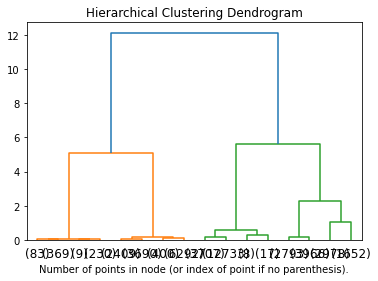

In [29]:
from scipy.cluster.hierarchy import dendrogram

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(hclustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [35]:
hclustering.n_clusters_

41336

In [ ]:
hclustering